**Fashion Search AI on Myntra Dataset**

**Objective:**

To Create a generative search system capable of searching a product descriptions to find and recommend appropriate choices against a user query. Utilize the Myntra dataset available on Kaggle to build such a system. (Dataset link: https://www.kaggle.com/datasets/djagatiya/myntra-fashion-product-dataset?select=Fashion+Dataset+v2.csv)

**Project Scope:**

The project should implement all three layers effectively. It will be key to try out various strategies and experiments in various layers in order to build an effective search system.

**The Embedding Layer:**

The CSV document needs to be effectively processed, cleaned, and prepared for embedding.

**The Search Layer:**

first need to design at least 3 queries against which you will test your system. Next, you need to embed the queries and search your vector database against each of these queries. Implementing a cache mechanism is also mandatory.

Finally, you need to implement the re-ranking block, and for this you can choose from a range of cross-encoding models on HuggingFace.

**The Generation Layer:**

In the generation layer, the final prompt that you design is the major component.

By effectively addressing each layer and conducting systematic experiments, the aim is to build a highly functional and efficient fashion search system tailored to meet user needs.

## **1. Install and Import the Required Libraries**

In [1]:
# Install all the required libraries

!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 720.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.6 MB/s eta

In [2]:
# Importing necessary libraries
import tiktoken  # Assuming this is a custom library for tokenization
import openai  # OpenAI library for accessing GPT models
import chromadb  # ChromaDB library for database operations
from pathlib import Path  # For handling file paths
import pandas as pd  # Pandas for data manipulation
from operator import itemgetter  # For sorting dictionaries
import json  # For working with JSON data
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer
from sklearn.metrics.pairwise import cosine_similarity  # Cosine similarity calculation
from nltk.corpus import stopwords  # Stopwords for text processing
from nltk.tokenize import word_tokenize  # Tokenization
import string  # String manipulation functions
from PIL import Image  # Image processing library
import requests  # For making HTTP requests
from io import BytesIO  # For handling binary data
import matplotlib.pyplot as plt  # Matplotlib for visualization
from matplotlib import table  # Table visualization in Matplotlib
import os  # Operating system utilities
import matplotlib.image as mpimg

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util
# Importing required functions and classes from ChromaDB
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# Importing the necessary library for mounting Google Drive
from google.colab import drive

# Mounting Google Drive to the Colab environment
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **2. Read, Process the csv Files**

In [4]:
# Define the file path to the Fashion Dataset CSV file
file_path = '/content/drive/MyDrive/Gen_AI_Fashion_AI/Fashion Dataset v2.csv'

# Read the Fashion Dataset CSV file into a Pandas DataFrame
fashion_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data has been loaded correctly
fashion_data.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

## **2.1 viewing image**

Let's view few images provided in the dataset.

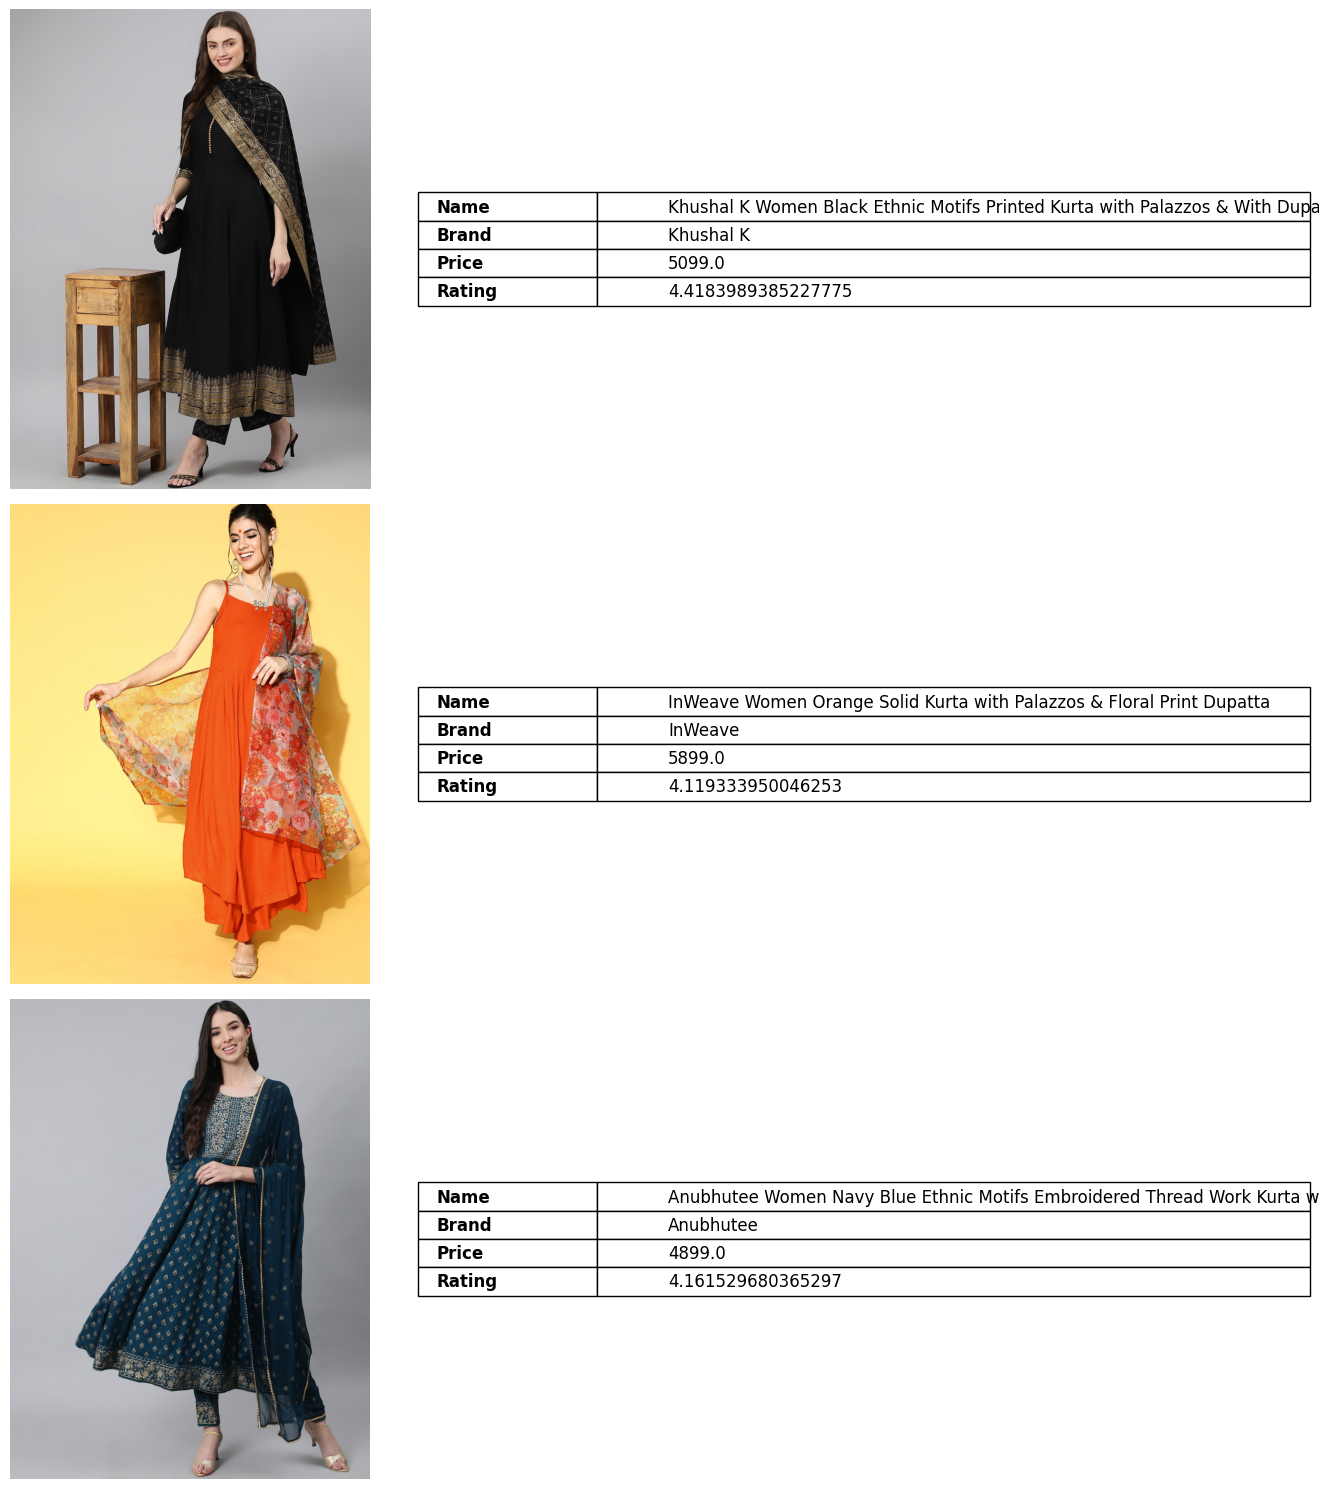

In [5]:
# Define the path to the images folder
images_folder_path = '/content/drive/MyDrive/Gen_AI_Fashion_AI/IMAGES'

# Define a function to display images with mini tables
def display_images_with_info(df, images_folder_path, num_images=3):
    """
    Display images with accompanying mini tables containing information from the DataFrame.

    Args:
    - df: DataFrame containing image information
    - images_folder_path: Path to the folder containing the images
    - num_images: Number of images to display

    Returns:
    None
    """
    # Create subplots to display images and mini tables
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

    # Iterate over each row in the DataFrame and display the image with mini table
    for i, (idx, row) in enumerate(df.head(num_images).iterrows()):
        # Construct the path to the image file
        image_path = os.path.join(images_folder_path, str(row['p_id']) + '.jpg')

        # Check if the image file exists
        if os.path.exists(image_path):
            # Open the image file
            img = Image.open(image_path)

            # Display the image
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')

            # Create a mini table with information from the DataFrame
            table_data = [['Name', row['name']],
                          ['Brand', row['brand']],
                          ['Price', row['price']],
                          ['Rating', row['avg_rating']]]

            axes[i, 1].axis('off')
            mini_table = axes[i, 1].table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.2, 0.8])

            # Format the mini table
            for cell in mini_table.get_celld().values():
                if cell.get_text().get_text() in ['Name', 'Brand', 'Price', 'Rating']:
                    cell.get_text().set_fontweight('bold')
                cell.get_text().set_fontsize(12)

            # Set font size explicitly for all cells
            mini_table.auto_set_font_size(False)
            mini_table.set_fontsize(12)
            mini_table.scale(1.2, 1.2)  # Adjust the scaling factor as needed
        else:
            print(f"Image not found for p_id: {row['p_id']}")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Display images with mini tables for the first 3 images
display_images_with_info(fashion_data, images_folder_path, num_images=3)

In [ ]:
# Print the columns of the fashion_data DataFrame
print(fashion_data.columns)


Index(['p_id', 'name', 'products', 'price', 'colour', 'brand', 'img',
       'ratingCount', 'avg_rating', 'description', 'p_attributes'],
      dtype='object')


In [ ]:
# Print the information about the fashion_data DataFrame
print(fashion_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          14214 non-null  int64  
 1   name          14214 non-null  object 
 2   products      14214 non-null  object 
 3   price         14214 non-null  float64
 4   colour        14214 non-null  object 
 5   brand         14214 non-null  object 
 6   img           14214 non-null  object 
 7   ratingCount   6530 non-null   float64
 8   avg_rating    6530 non-null   float64
 9   description   14214 non-null  object 
 10  p_attributes  14214 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB
None


**Dataset Chunking Explanation**

In this analysis, we have chosen not to perform dataset chunking. The reason for this decision is that our dataset is already structured with each data point residing in its respective rows and columns. Chunking, typically done to break down large datasets into smaller, more manageable chunks, would be necessary if our dataset exceeded a certain size or if we needed to process it in smaller portions based on specific parameters such as time, categories, or other criteria.

However, due to time constraints and the manageable size of our dataset, we have opted to skip the chunking process for the time being. While chunking could potentially offer benefits in terms of handling large volumes of data more efficiently, it is not currently deemed necessary for our analysis given the scope and scale of our dataset.

Should our dataset expand or our analysis requirements evolve, we may revisit the idea of implementing chunking as a means to optimize our data processing pipeline. For now, we will proceed with the dataset in its entirety, leveraging its existing structure to derive insights and perform analyses.

**3.Generate and Store Embeddings using OpenAI and ChromaDB**

In this section, we will embed the pages in the dataframe through OpenAI's text-embedding-ada-002 model, and store them in a ChromaDB collection.

**Embedding Layer**

In [10]:
# Define the file path to retrieve the API key
filepath = "/content/drive/MyDrive/Gen_AI_Fashion_AI"

# Read the API key from the text file and strip any leading or trailing whitespace
with open("/content/drive/MyDrive/Gen_AI_Fashion_AI/API_Key.txt", "r") as f:
    api_key = f.read().strip()

# Set the API key for OpenAI
openai.api_key = api_key

# Define the path for storing ChromaDB collections
chroma_data_path = '/content/drive/MyDrive/Gen_AI_Fashion_AI/Chroma_DB1'

# Initialize the ChromaDB client with the specified data path
client = chromadb.PersistentClient(path=chroma_data_path)

# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=api_key, model_name=model)

# Load the fashion dataset from the CSV file
file_path = '/content/drive/MyDrive/Gen_AI_Fashion_AI/Fashion Dataset v2.csv'
fashion_data = pd.read_csv(file_path)

# Convert the data to a dictionary format with metadata
fashion_data['metadata'] = fashion_data.apply(
    lambda x: {
        'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': x['description'],  # Description of the product
        'Product_attributes': x['p_attributes']  # Additional attributes of the product
    }, axis=1
)

# Function to extract text for embedding
def extract_text(metadata):
    """
    Extracts text content from the metadata dictionary for embedding.

    Args:
    metadata (dict): Dictionary containing metadata information.

    Returns:
    str: Text content extracted from the metadata.
    """
    text_content = ""
    if "Description" in metadata and metadata["Description"]:
        text_content += metadata["Description"]  # Add product description
    if "name" in metadata:
        text_content += " " + metadata["name"]  # Add product name
    if not text_content:
        text_content = "No description available."
    return text_content.strip()  # Strip leading and trailing whitespace

# Extract text for embedding from each row of metadata
documents = [extract_text(row['metadata']) for _, row in fashion_data.iterrows()]

# Get or create a ChromaDB collection for fashion products
fashion_collection = client.get_or_create_collection(name='Fashion_Products', embedding_function=embedding_function)

# Add the data to the ChromaDB collection
for idx, (p_id, metadata) in enumerate(zip(fashion_data['p_id'], fashion_data['metadata'])):
    print(f"Processing document with p_id={p_id}")
    print(f"Document text: {documents[idx]}")
    fashion_collection.add(documents=[documents[idx]],ids=[str(p_id)], metadatas=[metadata])

print("Data added to ChromaDB collection!")

Streaming output truncated to the last 5000 lines.
Processing document with p_id=11284562
Document text: Black checked culotte jumpsuit, has a V-neck, sleeveless<br><br>The model (height 5'8'') is wearing a size SMaterial: 100% Viscose<br>Hand Wash
Processing document with p_id=12411398
Document text: Green and white printed culotte jumpsuit, has a keyhole neck, three-quarter sleeves, 2 pockets, concealed zip closure<br>Comes with a beltThe model (height 5'8'') is wearing a size SMaterial: Cotton and flex blend<br>Hand Wash
Processing document with p_id=14218482
Document text: Rust orange&nbsp;solid&nbsp;layered basic jumpsuit, has an off-shoulder, short sleeves, 2 pockets, concealed zip closure<br>Comes with a fabric beltPolyester <br> Machine washThe model (height 5'8) is wearing a size S
Processing document with p_id=11148578
Document text: Navy Blue solid basic jumpsuit, has a shoulder straps, sleevelessThe model (height 5'8'') is wearing a size SMaterial: Polyester<br> Machine Was

KeyboardInterrupt: 

In [11]:
# Peek into the first 5 documents in the Fashion_Products collection
fashion_collection.peek(5)

{'ids': ['10016743', '10019867', '10035883', '10051259', '10053731'],
 'embeddings': [[-0.01229843683540821,
   0.000728239887394011,
   0.013846354559063911,
   -0.0027300831861793995,
   0.007354243192821741,
   0.013885542750358582,
   -0.01836601458489895,
   -0.013663478195667267,
   -0.006567221600562334,
   -0.028241338208317757,
   0.021527161821722984,
   0.014329670928418636,
   0.010691736824810505,
   -0.022807298228144646,
   -0.015805743634700775,
   0.009574884548783302,
   0.01655031181871891,
   0.010234545916318893,
   -0.0012703377287834883,
   -0.010339046828448772,
   -0.020194778218865395,
   0.018352951854467392,
   -0.0026713013648986816,
   -0.006420267280191183,
   0.010541517287492752,
   0.005901028867810965,
   0.0050029754638671875,
   -0.01751694455742836,
   0.019959650933742523,
   -0.0030925702303647995,
   -0.0018516234122216702,
   -0.008268624544143677,
   -0.005169523414224386,
   -0.035138390958309174,
   -0.012742565013468266,
   0.00735424319282

In [12]:
# Specify the name for the cache collection
cache_collection_name = 'Fashion_Cache'

# Create or retrieve the cache collection for fashion search using the PersistentClient
cache_collection = client.get_or_create_collection(name=cache_collection_name, embedding_function=embedding_function)

In [13]:
# Display a preview of the cache collection to inspect its contents
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}

**4. Semantic Search with Cache**

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [53]:
# Prompt the user to enter a fashion-related query with specific requirements
query = input("Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: ")

#Query 1: a orange summer dress or kurta to wear over blue denim jeans .
#Query 2: I'm looking for office wear sarees in elegant colors like pink, violet, or green. I prefer sarees with full embroidered designs, suitable for professional settings. There's no specific price range, as quality is my priority. These sarees will be worn for office meetings and formal events.
#Query 3: I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL.
#Query 4: "I'm seeking ethnic attire suitable for adults, with a preference for Ishin brand. These outfits are intended for festival wear. The clothing set I'm looking for should include a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves, along with a matching skirt featuring a drawstring closure. Both pieces should be made of pure cotton."
#Query 5: A silk purple summer dress, for beach party

Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: seeking ethnic attire suitable for adults, with a preference for Ishin brand. These outfits are intended for festival wear. The clothing set I'm looking for should include a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves, along with a matching skirt featuring a drawstring closure. Both pieces should be made of pure cotton


In [54]:
# Search the Cache collection first

cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=5  # Number of results to retrieve
)
cache_results

{'ids': [['office wear Saree, green',
   'Pink, No price limit, XL, ETHNIC',
   'XL size, versatile black leather jacket ']],
 'distances': [[0.39129765845577225, 0.3986520760255142, 0.45842184485104814]],
 'metadatas': [[{'distances0': '0.2562597990036011',
    'distances1': '0.2596498131752014',
    'distances2': '0.2604783773422241',
    'distances3': '0.2621055245399475',
    'distances4': '0.26257118582725525',
    'documents0': "Dark Green embroidered Kurta with Sharara<br><br><b>Kurta design: </b><ul><li>Ethnic motifs embroidered</li><li>A-line shape</li><li>Pleated style</li><li>Round neck, sleeveless no sleeves</li><li>Mirror work detail</li><li>Knee length with flared hem</li><li>Viscose rayon machine weave fabric</li></ul><br><b>Sharara design: </b><ul><li>Embroidered Sharara</li><li>Partially elasticated waistband</li><li>Slip-on closure</li></ul>The model (height 5'8) is wearing a size STop fabric: 100% Viscose Rayon<br>Bottom fabric: 100% Viscose Rayon<br>Hand wash",
    

### **Search Layer**

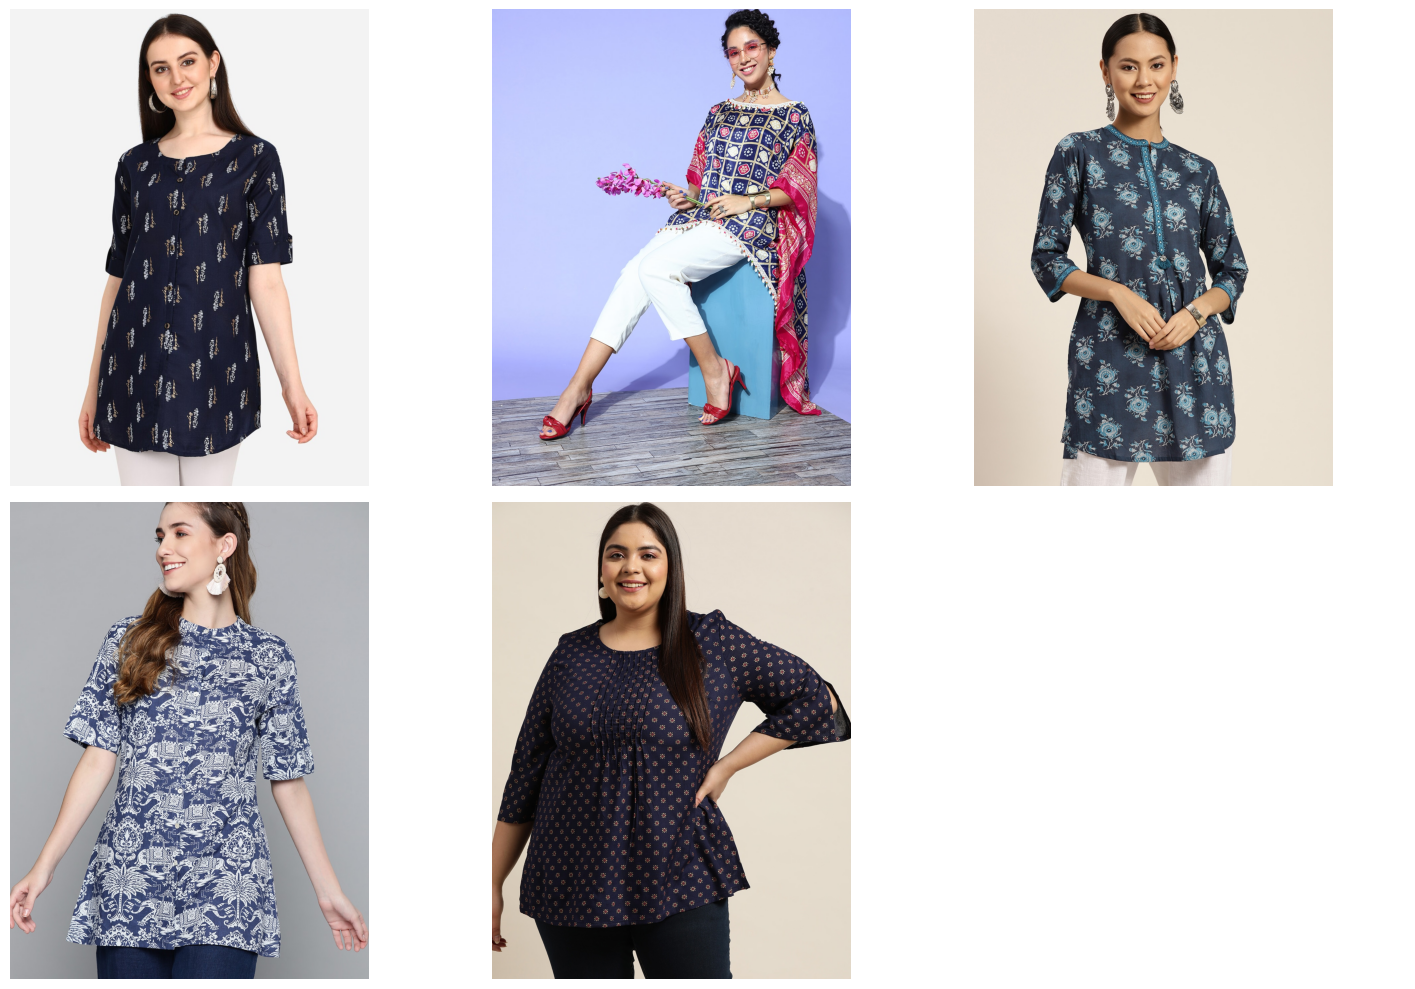

-------------------------------------------------------



dict_items([('ids', [['15352970', '18297822', '18882466', '15887108', '16276470']]), ('distances', [[0.30443018674850464, 0.30729103088378906, 0.30797454714775085, 0.30884289741516113, 0.31080833077430725]]), ('metadatas', [[{'Brand': 'OM SAI LATEST CREATION', 'Colour': 'Navy Blue', 'Description': "<ul> <li> Navy blue and gold-toned straight kurti </li> <li> Ethnic motifs printed </li> <li> Round neck,  three-quarter,  roll-up sleeves </li> <li> Knitted and woven regular pure cotton </li> </ul>90% Cotton , 10% Slub<br>Machine washThe model (height 5'8) is wearing a size S", 'Name': 'OM SAI LATEST CREATION Navy Blue & Gold-Toned Ethnic Motifs Printed Kurti', 'Price_INR': 1999.0, 'Product_attributes': "{'Body or Garment Size': 'Garment Measurements in', 'Care for me': 'iron with care', 'Design Styling': 'Regular', 'Fabric': 'Cotton Blend', 'Hemline': 'Straight', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Printed', 'Print or Pa

In [55]:
# Query the fashion collection to retrieve relevant fashion items based on the user query
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=5  # Number of results to retrieve, in this case, the top 3 most relevant results
)


import matplotlib.pyplot as plt
import os
from PIL import Image

# Assuming you have already obtained the search results in the variable 'results'

# Extract the IDs of the fashion items from the search results
item_ids = results['ids'][0]  # Assuming the IDs are stored as the first element of the list

# Calculate the number of images
num_images = len(item_ids)

# Define the number of columns for the grid layout
num_cols = 3

# Calculate the number of rows needed based on the number of images and number of columns
num_rows = (num_images + num_cols - 1) // num_cols

# Set up the plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display the images along with metadata
for i, item_id in enumerate(item_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"Image not found for item ID: {item_id}",
                     fontsize=12, ha='center', va='center')

# Hide any remaining empty subplots
for j in range(num_images, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


print("-------------------------------------------------------\n")
# Extract and display the items retrieved from the search operation
results.items()



In [56]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# Check if the distance is greater than the threshold, if so, return results from the main collection
if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the results
    results = fashion_collection.query(
        query_texts=query,
        n_results=5
    )

    # Store the query in cache_collection as a document with respect to ChromaDB for future reference
    # Store retrieved text, ids, distances, and metadatas in cache_collection as metadatas, so they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        for i in range(len(val[0])):  # Iterate over the actual length of val
            Keys.append(str(key) + str(i))
            if len(val[0]) > i:  # Check if the current index exists in val
                Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[query],
        metadatas=dict(zip(Keys, Values))
    )

    # Print message indicating the results are found in the main collection
    print("Not found in cache. Found in the main collection.")

    # Construct a DataFrame from the query results
    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)


# If the distance is less than the threshold, return results from the cache
elif cache_results['distances'][0][0] <= threshold and cache_results['ids']:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    # Print message indicating the results are found in the cache
    print("Found in cache!")

    # Create a DataFrame from the cached results
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })
else:
    # Print message indicating no valid results found in cache
    print("No valid results found in cache!")


Not found in cache. Found in the main collection.


Query: 
seeking ethnic attire suitable for adults, with a preference for Ishin brand.
These outfits are intended for festival wear.
The clothing set I'm looking for should include a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves, along with a matching skirt featuring a drawstring closure.
Both pieces should be made of pure cotton


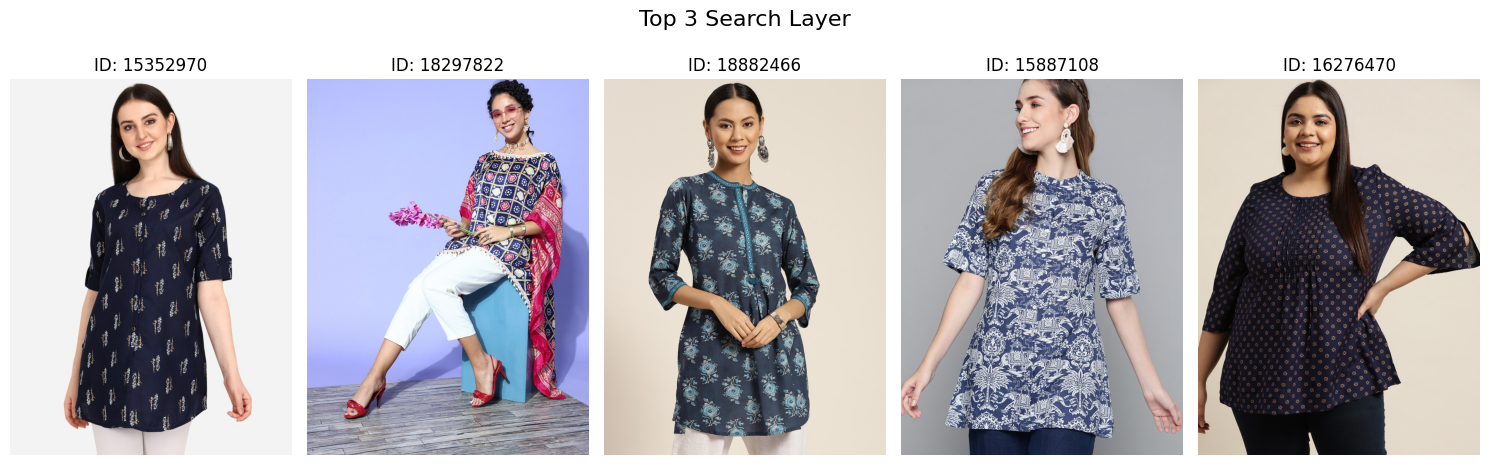

Metadatas  \
0  {'Brand': 'OM SAI LATEST CREATION', 'Colour': ...   
1  {'Brand': 'Rang Gali', 'Colour': 'Navy Blue', ...   
2  {'Brand': 'Rain & Rainbow', 'Colour': 'Navy Bl...   
3  {'Brand': 'HERE&NOW', 'Colour': 'Navy Blue', '...   
4  {'Brand': 'Sztori', 'Colour': 'Navy Blue', 'De...   

                                           Documents  Distances       IDs  
0  <ul> <li> Navy blue and gold-toned straight ku...   0.304430  15352970  
1  Highlight your stylish side by donning this cl...   0.307291  18297822  
2  <ul><li>Navy blue a-line kurti</li><li>Ethnic ...   0.307975  18882466  
3  <ul><li>Navy blue and white A-line kurti</li><...   0.308843  15887108  
4  <ul><li>Navy&nbsp;and golden&nbsp;a-line kurti...   0.310808  16276470

In [57]:
##For Screenshot

# Define the function to print query with a prefix and separator
def print_query_with_separator(prefix, query):
    # Print the prefix
    print(prefix)
    # Insert a newline character after every full stop
    query_with_newlines = query.replace(". ", ".\n")
    # Print the modified query
    print(query_with_newlines)

# Print the query with prefix and separator
print_query_with_separator("Query: ", query)

# Print the IDs from the results DataFrame
##print("IDs:")
#print(results_df['IDs'])


# Display images corresponding to the IDs side by side
num_images = len(results_df['IDs'])
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Set the title of the plot as the user query
fig.suptitle("Top 3 Search Layer", fontsize=16)

for i, item_id in enumerate(results_df['IDs']):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()

results_df

In [58]:
# Query the cache collection for results matching the user query
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

# Print the cache results
cache_results

{'ids': [["seeking ethnic attire suitable for adults, with a preference for Ishin brand. These outfits are intended for festival wear. The clothing set I'm looking for should include a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves, along with a matching skirt featuring a drawstring closure. Both pieces should be made of pure cotton"]],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.30443018674850464',
    'distances1': '0.30729103088378906',
    'distances2': '0.30797454714775085',
    'distances3': '0.30884289741516113',
    'distances4': '0.31080833077430725',
    'documents0': "<ul> <li> Navy blue and gold-toned straight kurti </li> <li> Ethnic motifs printed </li> <li> Round neck,  three-quarter,  roll-up sleeves </li> <li> Knitted and woven regular pure cotton </li> </ul>90% Cotton , 10% Slub<br>Machine washThe model (height 5'8) is wearing a size S",
    'documents1': "Highlight your stylish side by donning this classy top. Designed w

### 5**.Re-Ranking with a Cross Encoder**

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

In [59]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [60]:
# Create input pairs for the cross encoder, consisting of each query paired with each response
cross_inputs = [[query, response] for response in results_df['Documents']]

# Generate cross-encoder scores for the input pairs
cross_rerank_scores = cross_encoder.predict(cross_inputs)

# Display the cross-encoder scores
cross_rerank_scores


array([-3.4947348, -3.572988 , -5.0078597, -4.1761703, -4.1893063],
      dtype=float32)

In [61]:
# Add the cross-encoder scores to the results DataFrame
results_df['Reranked_scores'] = cross_rerank_scores

# Display the updated results DataFrame
results_df


Metadatas  \
0  {'Brand': 'OM SAI LATEST CREATION', 'Colour': ...   
1  {'Brand': 'Rang Gali', 'Colour': 'Navy Blue', ...   
2  {'Brand': 'Rain & Rainbow', 'Colour': 'Navy Bl...   
3  {'Brand': 'HERE&NOW', 'Colour': 'Navy Blue', '...   
4  {'Brand': 'Sztori', 'Colour': 'Navy Blue', 'De...   

                                           Documents  Distances       IDs  \
0  <ul> <li> Navy blue and gold-toned straight ku...   0.304430  15352970   
1  Highlight your stylish side by donning this cl...   0.307291  18297822   
2  <ul><li>Navy blue a-line kurti</li><li>Ethnic ...   0.307975  18882466   
3  <ul><li>Navy blue and white A-line kurti</li><...   0.308843  15887108   
4  <ul><li>Navy&nbsp;and golden&nbsp;a-line kurti...   0.310808  16276470   

   Reranked_scores  
0        -3.494735  
1        -3.572988  
2        -5.007860  
3        -4.176170  
4        -4.189306

In [62]:
# Return the top 3 results from semantic search based on the Distance
top_3_semantic = results_df.sort_values(by='Distances', ascending=False)[:3]

# Display the top 3 semantic search results
top_3_semantic

Metadatas  \
4  {'Brand': 'Sztori', 'Colour': 'Navy Blue', 'De...   
3  {'Brand': 'HERE&NOW', 'Colour': 'Navy Blue', '...   
2  {'Brand': 'Rain & Rainbow', 'Colour': 'Navy Bl...   

                                           Documents  Distances       IDs  \
4  <ul><li>Navy&nbsp;and golden&nbsp;a-line kurti...   0.310808  16276470   
3  <ul><li>Navy blue and white A-line kurti</li><...   0.308843  15887108   
2  <ul><li>Navy blue a-line kurti</li><li>Ethnic ...   0.307975  18882466   

   Reranked_scores  
4        -4.189306  
3        -4.176170  
2        -5.007860

In [63]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank

Metadatas  \
0  {'Brand': 'OM SAI LATEST CREATION', 'Colour': ...   
1  {'Brand': 'Rang Gali', 'Colour': 'Navy Blue', ...   
3  {'Brand': 'HERE&NOW', 'Colour': 'Navy Blue', '...   
4  {'Brand': 'Sztori', 'Colour': 'Navy Blue', 'De...   
2  {'Brand': 'Rain & Rainbow', 'Colour': 'Navy Bl...   

                                           Documents  Distances       IDs  \
0  <ul> <li> Navy blue and gold-toned straight ku...   0.304430  15352970   
1  Highlight your stylish side by donning this cl...   0.307291  18297822   
3  <ul><li>Navy blue and white A-line kurti</li><...   0.308843  15887108   
4  <ul><li>Navy&nbsp;and golden&nbsp;a-line kurti...   0.310808  16276470   
2  <ul><li>Navy blue a-line kurti</li><li>Ethnic ...   0.307975  18882466   

   Reranked_scores  
0        -3.494735  
1        -3.572988  
3        -4.176170  
4        -4.189306  
2        -5.007860

In [64]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas","IDs"]]
top_3_RAG

Documents  \
0  <ul> <li> Navy blue and gold-toned straight ku...   
1  Highlight your stylish side by donning this cl...   
3  <ul><li>Navy blue and white A-line kurti</li><...   
4  <ul><li>Navy&nbsp;and golden&nbsp;a-line kurti...   
2  <ul><li>Navy blue a-line kurti</li><li>Ethnic ...   

                                           Metadatas       IDs  
0  {'Brand': 'OM SAI LATEST CREATION', 'Colour': ...  15352970  
1  {'Brand': 'Rang Gali', 'Colour': 'Navy Blue', ...  18297822  
3  {'Brand': 'HERE&NOW', 'Colour': 'Navy Blue', '...  15887108  
4  {'Brand': 'Sztori', 'Colour': 'Navy Blue', 'De...  16276470  
2  {'Brand': 'Rain & Rainbow', 'Colour': 'Navy Bl...  18882466

### **6. Retrieval Augmented Generation**

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with brand,name and other information, rather than returning whole pages/chunks in a table format.

**Generation Layer**

Based on your query for ethnic attire suitable for adults with a preference for the Ishin brand, specifically looking for a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves along with a matching skirt made of pure cotton for festival wear, here are the relevant fashion items based on the provided dataset:

1. Item 1:
   - Description: Navy blue and gold-toned straight kurti
   - Brand: OM SAI LATEST CREATION
   - Additional Details: The kurti features intricate gold foil print on a navy blue base, suitable for festival wear.
   - ID: 15352970

2. Item 2:
   - Description: Ethnic Navy blue a-line kurti
   - Brand: Rain & Rainbow
   - Additional Details: While this item is slightly different from the specified preferences, it matches the color and style elements you are looking for and can be considered as an alternative.
   - ID: 18882466

3. Item 3:
   - Description: Navy Blue and golden a-line kurti
   - Brand: Sztori
   - Additional Details: This A-li

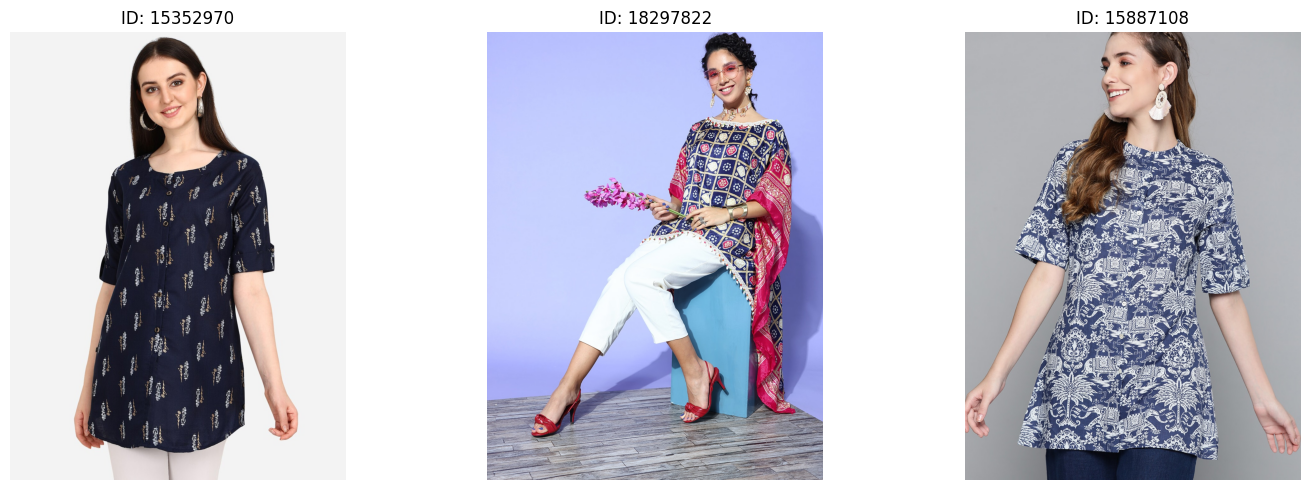

In [65]:
def generate_response_fashion(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {"role": "system", "content":  "You are a helpful AI assistant in the fashion domain, specialized in providing accurate answers to fashion-related queries."},
        {"role": "user", "content": f"""You have received a query from a user looking for fashion-related information. The query is: "{query}".
                                        Additionally, you have obtained the top 3 relevant results from the fashion dataset in the dataframe '{top_3_RAG}'.

                                        The 'Documents' column in this dataframe contains descriptions of fashion items, and the 'Metadatas' column contains additional information such as item name, brand.

                                        Your task is to use the information provided in '{top_3_RAG}' to generate a response to the query "{query}". Ensure that your response is informative and relevant to the user's query. Utilize the metadata to cite the relevant fashion items.

                                        Please adhere to the following guidelines:
                                        1. Provide accurate and relevant information based on the user query and the top 3 search results.
                                        2. You may use any relevant details from the dataframe to craft your response.
                                        3. If any of the fashion items contain tables or structured information, format and present it clearly.
                                        4. Use the metadata to cite the names, brands of the relevant fashion items.
                                        5. If you are unable to provide a complete answer, offer guidance on where the user can find further information within the cited fashion items.
                                        6. As a user-facing assistant, focus on delivering a direct and concise response without delving into technical details.
                                        7. Please note that detailed price and rating information might change from time to time. For more details,you should recommend to visit our website page.

                                        Your response should directly address the user's query and include citations for the referenced fashion items. Present the information in a well-organized and easily understandable format.
                                        """},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # Extracting p_ids directly from the 'IDs' column in top_3_RAG
    p_ids = top_3_RAG['IDs'].head(3).tolist()

    # Returning response and p_ids
    return response.choices[0].message.content, p_ids

# Generate response and p_ids based on the provided query and top_3_RAG DataFrame
response, p_ids = generate_response_fashion(query, top_3_RAG)

# Print the response
print(response)



# Display the images corresponding to the IDs obtained from the response side by side
num_images = len(p_ids)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, item_id in enumerate(p_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()


**Conclusion**

Comparing the search query results obtained from both the search layer and the generation layer, it's evident that the output from the generation layer is more detailed and easier to comprehend. While the search layer provides relevant results based on keyword matching or other predefined criteria, the generation layer leverages advanced AI models like GPT-3.5 to generate responses dynamically, incorporating context and generating detailed information tailored to the query.

The generation layer's ability to understand the query context and generate responses in natural language makes the output more informative and user-friendly. It can provide nuanced explanations, summaries, or even creative interpretations based on the input query. This results in responses that are not only relevant but also engaging and easy to read, enhancing the overall user experience.

Furthermore, the generation layer's flexibility allows it to adapt to various query formats and provide customized responses, catering to different user preferences and requirements. This versatility makes it a valuable tool for tasks requiring comprehensive understanding and communication of information.

In summary, while the search layer serves its purpose of retrieving relevant information efficiently, the generation layer significantly enhances the quality and readability of the output, making it a preferred choice for tasks where detailed and user-friendly responses are essential.